<a href="https://colab.research.google.com/github/IncharaG26/AIML_LAB/blob/main/Lab5_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading local dataset from /content/spam.csv ...
Label distribution before dropping rare labels: {'ham': 4825, 'spam': 747}
Label distribution after dropping rare labels: {'ham': 4825, 'spam': 747}
Loaded 5572 messages

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Test Accuracy: 0.9686
Saved confusion matrix to outputs/sms/cm_sms.png

=== Top 20 POSITIVE class-indicative features ===
txt                             4.551
uk                              3.474
claim                           3.451
mobile                          3.447
www                             3.298
reply                           3.028
free                            2.938
stop                    

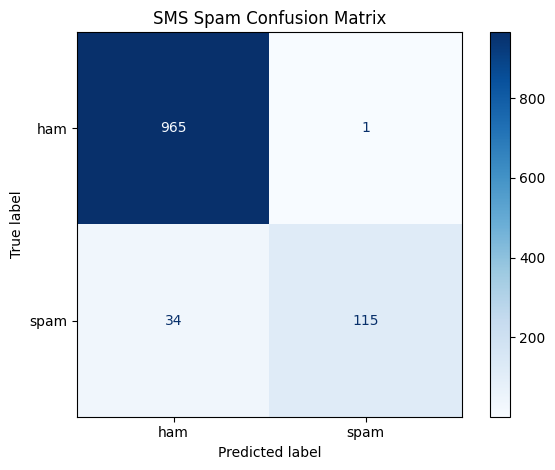

In [11]:
#6 sms Sapm detector
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# === Dataset sources ===
LOCAL_PATH = "/content/spam.csv"  # local fallback file
REMOTE_CSV = (
    "https://raw.githubusercontent.com/ozlerhakan/machine_learning_datasets/master/sms_spam.csv"
)  # backup remote dataset


# === Load and clean dataset ===
def load_data():
    """Load SMS Spam dataset, trying local file first, then remote, and normalize to [label, message]."""
    df = None

    # 1) Try local file
    if os.path.exists(LOCAL_PATH):
        print(f"Loading local dataset from {LOCAL_PATH} ...")
        # sep=None + engine="python" lets pandas auto-detect separator
        df = pd.read_csv(LOCAL_PATH, encoding="latin1", sep=None, engine="python")

    # 2) Fallback to remote
    if df is None:
        try:
            print(f"Loading remote dataset from {REMOTE_CSV} ...")
            df = pd.read_csv(REMOTE_CSV, encoding="latin1")
        except Exception as e:
            raise RuntimeError(
                "Could not load SMS dataset.\n"
                "Place a valid 'spam.csv' next to this script "
                "or ensure internet is available."
            ) from e

    # --- Normalize column names to ['label', 'message'] ---
    cols = [c.strip().lower() for c in df.columns]
    df.columns = cols

    # Common patterns for SMS spam dataset
    if {"v1", "v2"}.issubset(df.columns):
        df = df[["v1", "v2"]]
        df.columns = ["label", "message"]
    elif {"label", "message"}.issubset(df.columns):
        df = df[["label", "message"]]
    elif {"category", "message"}.issubset(df.columns):
        df = df[["category", "message"]]
        df.columns = ["label", "message"]
    else:
        # Fallback: assume first two columns are label + message
        if len(df.columns) < 2:
            raise RuntimeError(
                f"Expected at least 2 columns (label, message), got {df.columns}"
            )
        df = df.iloc[:, :2]
        df.columns = ["label", "message"]

    # --- Basic cleaning ---
    df = df.dropna(subset=["label", "message"]).copy()
    df["label"] = df["label"].astype(str).str.strip().str.lower()
    df["message"] = df["message"].astype(str).str.strip()

    # Drop empty messages if any
    df = df[df["message"].str.len() > 0]

    # --- Handle rare labels (fix for 'least populated class has only 1 member') ---
    vc = df["label"].value_counts()
    print("Label distribution before dropping rare labels:", vc.to_dict())

    rare_labels = vc[vc < 2].index.tolist()
    if rare_labels:
        print("Dropping rare labels (likely header / noise rows):", rare_labels)
        df = df[~df["label"].isin(rare_labels)].copy()

    vc_after = df["label"].value_counts()
    print("Label distribution after dropping rare labels:", vc_after.to_dict())

    if vc_after.shape[0] < 2:
        raise RuntimeError(
            f"Need at least 2 distinct labels after cleaning, got: {vc_after.to_dict()}"
        )

    return df


# === Main workflow ===
def main():
    # Prepare output folder
    os.makedirs("outputs/sms", exist_ok=True)

    # Load dataset
    df = load_data()
    print(f"Loaded {len(df)} messages")

    # Split data into train/test sets (with stratification)
    X = df["message"].values
    y = df["label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    # TF-IDF vectorizer setup
    vect = TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=2,
    )

    Xtr = vect.fit_transform(X_train)
    Xte = vect.transform(X_test)

    # Logistic Regression classifier
    clf = LogisticRegression(
        penalty="l2", solver="liblinear", max_iter=1000
    )
    clf.fit(Xtr, y_train)

    # Predict test set
    y_pred = clf.predict(Xte)

    # === Evaluation ===
    print("\n=== Classification Report (Test Set) ===")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Confusion Matrix (assuming labels are 'ham' and 'spam')
    labels_order = sorted(np.unique(y_train))
    cm = confusion_matrix(y_test, y_pred, labels=labels_order)

    disp = ConfusionMatrixDisplay(cm, display_labels=labels_order)
    disp.plot(cmap="Blues")
    plt.title("SMS Spam Confusion Matrix")
    plt.tight_layout()
    plt.savefig("outputs/sms/cm_sms.png", dpi=200)
    print("Saved confusion matrix to outputs/sms/cm_sms.png")

    # === Feature Analysis ===
    feature_names = np.array(vect.get_feature_names_out())
    coefs = clf.coef_[0]  # binary classification → shape (1, n_features)

    # Top 20 spam- and ham-indicative features
    top_pos = np.argsort(coefs)[-20:][::-1]  # highest positive weights
    top_neg = np.argsort(coefs)[:20]         # most negative weights

    print("\n=== Top 20 POSITIVE class-indicative features ===")
    for f, w in zip(feature_names[top_pos], coefs[top_pos]):
        print(f"{f:30s} {w: .3f}")

    print("\n=== Top 20 NEGATIVE class-indicative features ===")
    for f, w in zip(feature_names[top_neg], coefs[top_neg]):
        print(f"{f:30s} {w: .3f}")


# === Run the script ===
if __name__ == "__main__":
    main()


Logistic Regression 5-fold CV accuracy: 0.9533 ± 0.0452

Logistic Regression per-class metrics:
  class    prec     rec      f1  support
      0   1.000   1.000   1.000       50
      1   0.922   0.940   0.931       50
      2   0.939   0.920   0.929       50

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.92      0.94      0.93        50
   virginica       0.94      0.92      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150

Saved: outputs/iris/cm_logistic_regression.png
Linear SVM 5-fold CV accuracy: 0.9267 ± 0.0533

Linear SVM per-class metrics:
  class    prec     rec      f1  support
      0   1.000   0.980   0.990       50
      1   0.898   0.880   0.889       50
      2   0.885   0.920   0.902       50

Classification report:
              precisio

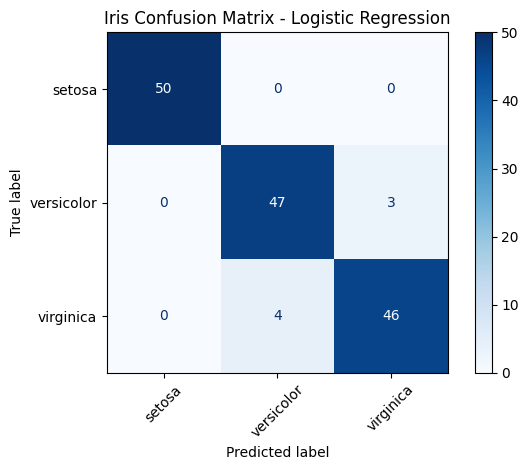

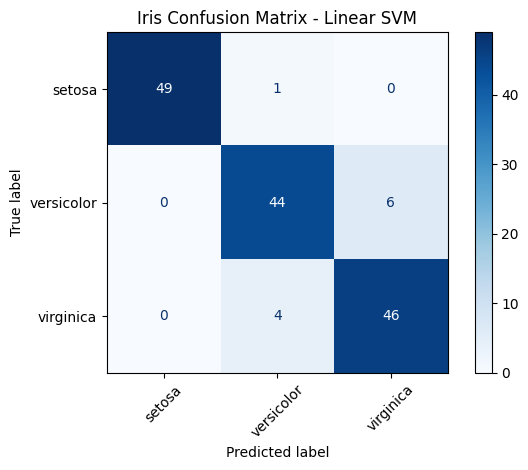

In [13]:
import os
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
def ensure_out():
    os.makedirs("outputs/iris", exist_ok=True)
def pr_table(y_true, y_pred, labels):
    p, r, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    header = f"{'class':>7} {'prec':>7} {'rec':>7} {'f1':>7} {'support':>8}"
    print(header)
    for c, pp, rr, ff, ss in zip(labels, p, r, f1, sup):
        print(f"{c:>7} {pp:7.3f} {rr:7.3f} {ff:7.3f} {ss:8d}")
def decision_plot_2d(model, X2d, y, title, fname, h=0.03):
    x_min, x_max = X2d[:, 0].min()-1, X2d[:, 0].max()+1
    y_min, y_max = X2d[:, 1].min()-1, X2d[:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    for c in np.unique(y):
        idx = (y == c)
        plt.scatter(X2d[idx, 0], X2d[idx, 1], s=20, edgecolors='k', label=str(c))
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2");
    plt.legend(fontsize=8)

    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.close()
def main():
    ensure_out()
    data = load_iris()
    X, y, names = data.data, data.target, data.target_names
    pipe_lr = Pipeline([("scaler", StandardScaler()),
                        ("clf",
                         LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1))])
    pipe_lsvm = Pipeline([("scaler", StandardScaler()),
                          ("clf", LinearSVC(C=1.0))])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for label, model in [("Logistic Regression", pipe_lr), ("Linear SVM", pipe_lsvm)]:

        scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")

        print(f"{label} 5-fold CV accuracy: {scores.mean():.4f} \u00b1 {scores.std():.4f}")

        y_pred = cross_val_predict(model, X, y, cv=cv)
        cm = confusion_matrix(y, y_pred)
        print(f"\n{label} per-class metrics:")
        pr_table(y, y_pred, labels=[0,1,2])
        print("\nClassification report:")
        print(classification_report(y, y_pred, target_names=names, zero_division=0))

        disp = ConfusionMatrixDisplay(cm, display_labels=names)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Iris Confusion Matrix - {label}")
        out = f"outputs/iris/cm_{label.replace(' ','_').lower()}.png"
        plt.tight_layout(); plt.savefig(out, dpi=200);
        print(f"Saved: {out}")
    # PCA(2D) visualization models (trained on 2D only for plotting)
    X2d = PCA(n_components=2, random_state=42).fit_transform(X)

    lr2d = LogisticRegression(solver="lbfgs", max_iter=1000).fit(X2d, y)
    decision_plot_2d(lr2d, X2d, y, "Iris Decision Regions (PCA) LogReg", "outputs/iris/decision_lr.png")
    lsvm2d = LinearSVC(C=1.0).fit(X2d, y)
    decision_plot_2d(lsvm2d, X2d, y, "Iris Decision Regions (PCA) - LinearSVM", "outputs/iris/decision_lsvm.png")
if __name__ == "__main__":
    main()

Using 10000 train samples and 2000 test samples

Fitting Logistic Regression (light)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic baseline test accuracy (subset): 0.8815

Training small MLP (CPU-friendly)...
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4016 - loss: 1.8060 - val_accuracy: 0.8680 - val_loss: 0.5138
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8060 - loss: 0.6474 - val_accuracy: 0.8970 - val_loss: 0.3601
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8684 - loss: 0.4457 - val_accuracy: 0.9100 - val_loss: 0.3040
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8945 - loss: 0.3616 - val_accuracy: 0.9230 - val_loss: 0.2722
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9067 - loss: 0.3173 - val_accuracy: 0.9220 - val_loss: 0.2578
Keras MLP test accuracy (subset, small model): 0.8985
Saved: outputs/mnist/cm_mlp.png


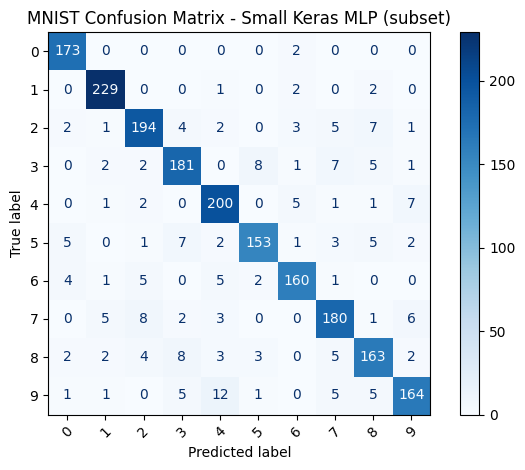

In [17]:
# mnist_mlp_vs_logistic_light.py
# Lightweight version for CPU-only (Colab / i5)
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping


def ensure_out():
    os.makedirs("outputs/mnist", exist_ok=True)


def main():
    ensure_out()

    # --- Load MNIST ---
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    # ====== use smaller subsets for speed ======
    # You can tweak these; smaller -> faster
    N_TRAIN = 10000   # out of 60000
    N_TEST = 2000     # out of 10000

    X_train = X_train[:N_TRAIN]
    y_train = y_train[:N_TRAIN]
    X_test = X_test[:N_TEST]
    y_test = y_test[:N_TEST]

    print(f"Using {len(X_train)} train samples and {len(X_test)} test samples")

    # =======================
    # 1) Logistic Regression
    # =======================
    X_train_flat = X_train.reshape((X_train.shape[0], -1)).astype("float32") / 255.0
    X_test_flat = X_test.reshape((X_test.shape[0], -1)).astype("float32") / 255.0

    # Standardize features (helps LR convergence)
    scaler = StandardScaler(with_mean=False)  # with_mean=False is faster for sparse-like data
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Lighter logistic regression: fewer iterations
    logreg = LogisticRegression(
        solver="saga",
        multi_class="multinomial",
        max_iter=60,      # reduced from 200
        n_jobs=-1,
        verbose=0,
    )

    print("\nFitting Logistic Regression (light)...")
    logreg.fit(X_train_scaled, y_train)
    y_pred_lr = logreg.predict(X_test_scaled)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic baseline test accuracy (subset): {acc_lr:.4f}")

    # =======================
    # 2) Small MLP with dropout + early stopping
    # =======================
    X_train_n = X_train.astype("float32") / 255.0
    X_test_n = X_test.astype("float32") / 255.0

    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation="relu"),    # smaller hidden layer
        Dropout(0.2),
        Dense(64, activation="relu"),     # smaller second layer
        Dropout(0.2),
        Dense(10, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    es = EarlyStopping(
        monitor="val_accuracy",
        patience=1,           # stop quickly if no improvement
        restore_best_weights=True,
    )

    print("\nTraining small MLP (CPU-friendly)...")
    history = model.fit(
        X_train_n,
        y_train,
        validation_split=0.1,
        epochs=8,            # few epochs
        batch_size=256,      # larger batch for speed
        callbacks=[es],
        verbose=1,
    )

    test_loss, test_acc = model.evaluate(X_test_n, y_test, verbose=0)
    print(f"Keras MLP test accuracy (subset, small model): {test_acc:.4f}")

    # =======================
    # Confusion matrix for MLP
    # =======================
    y_pred_mlp = np.argmax(model.predict(X_test_n, verbose=0), axis=1)
    cm = confusion_matrix(y_test, y_pred_mlp)
    disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("MNIST Confusion Matrix - Small Keras MLP (subset)")
    plt.tight_layout()
    plt.savefig("outputs/mnist/cm_mlp.png", dpi=200)
    print("Saved: outputs/mnist/cm_mlp.png")


if __name__ == "__main__":
    main()


Linear SVM CV accuracy: 0.9794 ± 0.0033
RBF SVM CV accuracy: 0.9839 ± 0.0060
Best RBF params: {'C': 10, 'gamma': 0.01}, best CV accuracy: 0.9827
Saved: outputs/svm/heatmap_rbf.png
Saved: outputs/svm/sv_linear.png, outputs/svm/sv_rbf.png


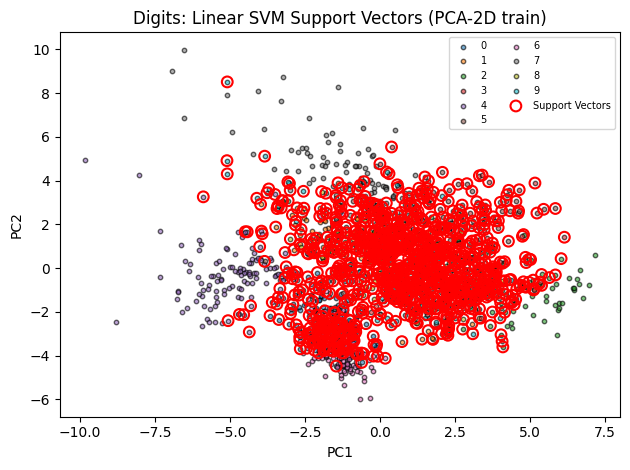

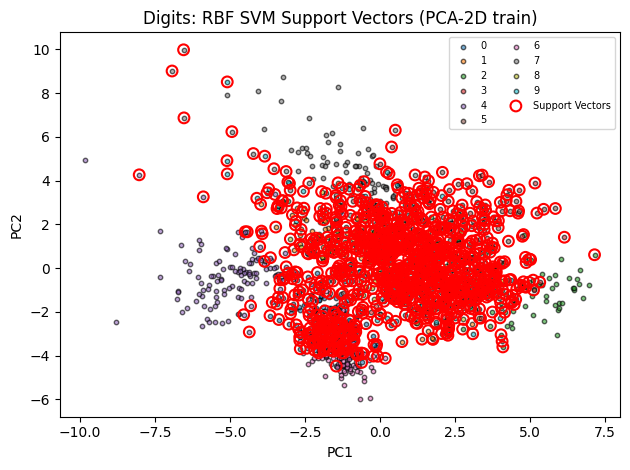

In [19]:
# svm_kernels_margins_digits.py
# Digits dataset: Linear vs RBF SVM with grid search over (C, gamma),
# support-vector visualization (in PCA 2D), and accuracy heatmap.

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA


def ensure_out():
    os.makedirs("outputs/svm", exist_ok=True)


def heatmap(Z, Cs, gammas, title, fname):
    plt.figure()
    im = plt.imshow(Z, origin="lower", aspect="auto")
    plt.colorbar(im, label="CV Accuracy")
    plt.xticks(np.arange(len(gammas)), gammas)
    plt.yticks(np.arange(len(Cs)), Cs)
    plt.xlabel("gamma")
    plt.ylabel("C")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.close()


def plot_sv_2d(clf, X2d, y, title, fname):
    plt.figure()

    # Plot points
    for c in np.unique(y):
        idx = (y == c)
        plt.scatter(
            X2d[idx, 0],
            X2d[idx, 1],
            s=10,
            edgecolors="k",
            alpha=0.6,
            label=str(c),
        )

    # Support vectors
    sv = clf.support_vectors_
    plt.scatter(
        sv[:, 0],
        sv[:, 1],
        s=60,
        facecolors="none",
        edgecolors="r",
        linewidths=1.5,
        label="Support Vectors",
    )

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="best", fontsize=7, ncol=2)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)



def main():
    ensure_out()

    # Load digits dataset
    X, y = load_digits(return_X_y=True)

    # Scale features
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Baselines: linear vs RBF
    lin = SVC(kernel="linear", C=1.0)  # use SVC to access support_vectors_
    rbf = SVC(kernel="rbf", C=1.0, gamma="scale")

    lin_scores = cross_val_score(lin, Xs, y, cv=cv, scoring="accuracy")
    rbf_scores = cross_val_score(rbf, Xs, y, cv=cv, scoring="accuracy")

    print(
        f"Linear SVM CV accuracy: {lin_scores.mean():.4f} "
        f"± {lin_scores.std():.4f}"
    )
    print(
        f"RBF SVM CV accuracy: {rbf_scores.mean():.4f} "
        f"± {rbf_scores.std():.4f}"
    )

    # Grid over C and gamma for RBF
    param_grid = {
        "C": [0.1, 1, 10, 100],
        "gamma": [1e-3, 1e-2, 1e-1, 1.0],
    }

    grid = GridSearchCV(
        SVC(kernel="rbf"),
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        return_train_score=False,
    )
    grid.fit(Xs, y)

    print(
        f"Best RBF params: {grid.best_params_}, "
        f"best CV accuracy: {grid.best_score_:.4f}"
    )

    means = grid.cv_results_["mean_test_score"].reshape(
        len(param_grid["C"]), len(param_grid["gamma"])
    )

    heatmap(
        means,
        param_grid["C"],
        param_grid["gamma"],
        "RBF SVM Grid Search Accuracy",
        "outputs/svm/heatmap_rbf.png",
    )
    print("Saved: outputs/svm/heatmap_rbf.png")

    # Visualize support vectors in PCA 2D (train split)
    Xtr, Xte, ytr, yte = train_test_split(
        Xs,
        y,
        test_size=0.25,
        stratify=y,
        random_state=42,
    )

    pca = PCA(n_components=2, random_state=42)
    Xtr2 = pca.fit_transform(Xtr)

    lin2 = SVC(kernel="linear", C=1.0).fit(Xtr2, ytr)
    rbf2 = SVC(
        kernel="rbf",
        C=grid.best_params_["C"],
        gamma=grid.best_params_["gamma"],
    ).fit(Xtr2, ytr)

    plot_sv_2d(
        lin2,
        Xtr2,
        ytr,
        "Digits: Linear SVM Support Vectors (PCA-2D train)",
        "outputs/svm/sv_linear.png",
    )
    plot_sv_2d(
        rbf2,
        Xtr2,
        ytr,
        "Digits: RBF SVM Support Vectors (PCA-2D train)",
        "outputs/svm/sv_rbf.png",
    )
    print("Saved: outputs/svm/sv_linear.png, outputs/svm/sv_rbf.png")


if __name__ == "__main__":
    main()
